In [ ]:
# Import Packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Sklearn Packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import set_config
from xgboost import XGBClassifier
from sklearn.exceptions import ConvergenceWarning
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', 300)

plt.style.use('seaborn')


In [ ]:
#Read in dataframe
exp_df = pd.read_csv('experiment_features.csv', index_col=0)
exp_df.head()

vanilla_df = pd.read_csv('fetal_health.csv')
X = vanilla_df.drop('fetal_health', axis =1)

In [ ]:
# Evaluation function
def evaluation(y_true, y_pred):

# Print Accuracy, Recall, F1 Score, and Precision metrics.
    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))

# Print Confusion Matrix
    print('\nConfusion Matrix:')
    print(' TN,  FP, FN, TP')
    print(confusion_matrix(y_true, y_pred).ravel())

# Function Prints best parameters for GridSearchCV
def print_results(results):
    print('Best Parameters: {}\n'.format(results.best_params_))

In [ ]:
#train test split of data
X = exp_df.drop('fetal_health', axis =1)
y = exp_df.fetal_health

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=1)

In [ ]:
#standared scaler for predicting features
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

## Class imbalance
- To handle class imbalance we oversampled the minority class using SMOTE(Synthetic Minority Oversampling Technique), this balanced the minority class by sampling the nearest neighboors and adding points between the neighbors.  We used both a SMOTE sampled database and unbalanced database to compare the effect of the metrics for each experimental baseline model.  The Smote Database preformed better on every baseline model, we chose to use the SMOTE database for our final models.  


In [ ]:
# Used SMOTE to oversample the minority class
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=25)
smX_train, smy_train = sm.fit_resample(X_train, y_train)


##KNN

In [ ]:
#baseline KNN with class imbalance
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred = knn.predict(X_test)
#prediction metrics and confusion matrix of base KNN with class imbalance
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9172932330827067
Recall: 0.9682151589242054
F1 Score: 0.9473684210526315
Precision: 0.927400468384075

Confusion Matrix:
 TN,  FP, FN, TP
[396  13  31  92]


In [ ]:
#Base KNN model with Smote oversampled class
smknn = KNeighborsClassifier(n_neighbors=1)
smknn.fit(smX_train,smy_train)
y_pred = smknn.predict(X_test)

In [ ]:
#Prediction metrics and confusion matrix of smote base KNN
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9135338345864662
Recall: 0.9535452322738386
F1 Score: 0.9443099273607748
Precision: 0.935251798561151

Confusion Matrix:
 TN,  FP, FN, TP
[390  19  27  96]


## Logistic Regression Basline Model


In [ ]:
#Fit Train set with Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [ ]:
#Regression model evaluation metrics and confusion matrix
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.8759398496240601
Recall: 0.9388753056234719
F1 Score: 0.920863309352518
Precision: 0.9035294117647059

Confusion Matrix:
 TN,  FP, FN, TP
[384  25  41  82]


In [ ]:
smlr = LogisticRegression(solver='liblinear')
smlr.fit(smX_train,smy_train)
y_predsm = smlr.predict(X_test)
evaluation(y_test, y_predsm)

Evaluation Metrics:
Accuracy: 0.8909774436090225
Recall: 0.8948655256723717
F1 Score: 0.9265822784810127
Precision: 0.9606299212598425

Confusion Matrix:
 TN,  FP, FN, TP
[366  43  15 108]


# Below is a table of feature coefficients for the Logistic Regression.  

The greatest feature Coefficients are **sqrt_total_change, quant_acc_1, quant_hist_mean(1 2 and 3) and tendancy_1**. All of these features are ones that we engineered.

 Looking at what these features represent, for this model, the

*   change in the rate of FHR
*   and the average change in that rate

seem to be the biggest factors for classifying fetal health.  We wanted to try and improve the Logistic regression by tuning the hyperparameters to improve both the recall and precision.  To attempt this we used a **bagging classifer** to train the logistic regression on multiple random samples and aggrigate the predictions to see how that effected the evaluation metrics.  

In [ ]:
#Create a table of logistic regression coefficients and comparing the coefficients
#of the SMOTE and inbalanced datasets
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',smlr.coef_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','Coefs','del','sm_Coefs']
del smote_vs_coef['del']
smote_vs_coef

,features,Coefs,sm_Coefs
0,baseline value,0.114307,0.108869
1,accelerations,-0.004013,-0.196622
2,fetal_movement,0.010639,0.278605
3,uterine_contractions,-0.005219,-0.054559
4,light_decelerations,-0.002178,-0.028781
5,prolongued_decelerations,0.000791,0.039519
6,abnormal_short_term_variability,0.068212,0.082435
7,mean_value_of_short_term_variability,-0.701397,-0.577582
8,percentage_of_time_with_abnormal_long_term_var...,0.037503,0.040345
9,mean_value_of_long_term_variability,0.030654,0.044462


#Bagging classifier for logistic regression


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# Bagging classifier for logistic regression
bag_log = BaggingClassifier(
    estimator=LogisticRegression(random_state=1),
    n_estimators=200,
    max_samples=100,
    bootstrap=True,
    random_state=1
)



In [ ]:
#Fit bagging classifier
bag_log.fit(smX_train, smy_train)
y_pred = bag_log.predict(X_test)

In [ ]:
#Evaluation Metrics
evaluation(y_test,y_pred)

Evaluation Metrics:
Accuracy: 0.8590225563909775
Recall: 0.8655256723716381
F1 Score: 0.9042145593869731
Precision: 0.946524064171123

Confusion Matrix:
 TN,  FP, FN, TP
[354  55  20 103]


- The Bagging classifer made only minute changes to the evaluation metrics.  We decided to look at some other models and compare the results.

## Decision Tree

- The next model we tried was a decision tree.
 Again we compare the imbalanced and SMOTE data sets on baseline models to observe the effect on the metrics.  

In [ ]:
#Train decision tree with train set and predict on the test set
tree = DecisionTreeClassifier()

tree = tree.fit(X_train,y_train)

y_pred = tree.predict(X_test)
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.9154135338345865
Recall: 0.9290953545232273
F1 Score: 0.9440993788819876
Precision: 0.9595959595959596

Confusion Matrix:
 TN,  FP, FN, TP
[380  29  16 107]


In [ ]:
#Decision tree with smote dataset
smtree = DecisionTreeClassifier()
smtree.fit(smX_train,smy_train)
y_pred = smtree.predict(X_test)
#evaluation Metrics
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.924812030075188
Recall: 0.9486552567237164
F1 Score: 0.9509803921568627
Precision: 0.9533169533169533

Confusion Matrix:
 TN,  FP, FN, TP
[388  21  19 104]


- With the SMOTE data set, decision tree produced very good metrics with all default hyperparamers.  The most important features where abnormal_short_term_variability, and mean_value_of_short_term_variability

In [ ]:
#Table for decision tree feature coefficients
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",tree.feature_importances_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',tree.feature_importances_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','importance','del','sm_importance']
del smote_vs_coef['del']
smote_vs_coef

,features,importance,sm_importance
0,baseline value,0.046170,0.046170
1,accelerations,0.019693,0.019693
2,fetal_movement,0.011412,0.011412
3,uterine_contractions,0.012703,0.012703
4,light_decelerations,0.000000,0.000000
5,prolongued_decelerations,0.028585,0.028585
6,abnormal_short_term_variability,0.338751,0.338751
7,mean_value_of_short_term_variability,0.107879,0.107879
8,percentage_of_time_with_abnormal_long_term_var...,0.046743,0.046743
9,mean_value_of_long_term_variability,0.012098,0.012098


## Random Forest

In [ ]:
#Random Forest classifier using 50 estimators and a max depth of 3
rfc = RandomForestClassifier(random_state =1, n_estimators= 50, max_depth = 3, n_jobs =-1,verbose=1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [ ]:
#Evaluation metrics for random forest
evaluation(y_test, y_pred)

Evaluation Metrics:
Accuracy: 0.900375939849624
Recall: 0.9828850855745721
F1 Score: 0.9381563593932322
Precision: 0.8973214285714286

Confusion Matrix:
 TN,  FP, FN, TP
[402   7  46  77]


In [ ]:
#Random Forest classifier using 50 estimators and a max depth of 3 using SMOTE dataset
smrfc = RandomForestClassifier(random_state =1, n_estimators= 50, max_depth = 3, n_jobs =-1,verbose=1)
smrfc.fit(smX_train,smy_train)
y_pred = smrfc.predict(X_test)

print(confusion_matrix(y_test, y_pred))
evaluation(y_test, y_pred)

[[380  29]
 [ 17 106]]
Evaluation Metrics:
Accuracy: 0.9135338345864662
Recall: 0.9290953545232273
F1 Score: 0.9429280397022333
Precision: 0.9571788413098237

Confusion Matrix:
 TN,  FP, FN, TP
[380  29  17 106]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [ ]:
#Create table of feature coefficients
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",rfc.feature_importances_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',smrfc.feature_importances_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','importance_baseline','del','sm_importance_baseline']
del smote_vs_coef['del']
smote_vs_coef

,features,importance_baseline,sm_importance_baseline
0,baseline value,9.926765e-03,0.014390
1,accelerations,1.035325e-01,0.202823
2,fetal_movement,4.708818e-03,0.002555
3,uterine_contractions,1.058922e-02,0.025497
4,light_decelerations,6.170803e-04,0.001446
5,prolongued_decelerations,8.764041e-02,0.082055
6,abnormal_short_term_variability,1.576849e-01,0.171495
7,mean_value_of_short_term_variability,1.492258e-01,0.105107
8,percentage_of_time_with_abnormal_long_term_var...,8.983866e-02,0.077031
9,mean_value_of_long_term_variability,1.227784e-02,0.009800


## Grid Search Random Forest
- We ran a gridsearch on the random forest to identify what the best hyperparamters where for the model.  We checked several estimator sizes, max depth and min weight fraction leaf to find the ideal parameters.  

In [ ]:
#parameter grid for grid search with lists of estimators, both criterion, a list of max depths sqrt max features
#and a list of min weight fraction leaf
parameters = {
    'n_estimators': [25,50,100,300,500],
    'criterion' : ['gini','entropy'],
    'max_depth' : [8,9,10,11,12],
    'max_features' : ['sqrt'],
    'min_weight_fraction_leaf' : [0,0.1,0.3,0.5],



}

In [ ]:
#Gridsearch with random forest
grid_tree=GridSearchCV(RandomForestClassifier(), parameters, cv=15, scoring='f1', verbose=1, n_jobs=-1)

In [ ]:
#Fit random forest grid serch to SMOTE train set
grid_tree.fit(smX_train, smy_train)

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


KeyboardInterrupt: 

In [ ]:
#Find the best score, best parameters and best estimator for grid search
print(grid_tree.best_score_)
print(grid_tree.best_params_)
print(grid_tree.best_estimator_)

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
#evaluation metrics for random forest gridsearch best parameters
y_pred = grid_tree.best_estimator_.predict(X_test)
evaluation(y_test,y_pred)

**Findings:**
- The best parameters for the random forest was a max depth of 11, min weight fraction leave of 0, and 500 estimators.  The Evaluation metrics where our highest score with the experimental set so far.  Below we compared feature importance for the three random forest models we ran and then graphed the top ten important features to visualize there importance for fetal health classification.

In [ ]:
#Best feature table for random forest gridsearch best parameters
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",grid_tree.best_estimator_.feature_importances_.transpose())
coef_table

In [ ]:
#table comparing random forest best features between imbalanced data set, smote and smote with gridsearch best features
coef_table.columns = ['features','grid_search_importance']
del coef_table['features']
best_features_rfc = pd.concat([smote_vs_coef,coef_table],axis=1)

In [ ]:
best_features_rfc

**Findings**
- In the below graphs we see the top 10 importanct features for our grid search random foret model.

*   Abnormal_short_term_variatability,
*   acceleration
*   mean_value_of_short_term_varitability

seem to be key factors in health classification.  We can infer from this that extended rapid extreme changes in fetal heart rate are detrimental to fetal health.

In [ ]:
pd.Series(grid_tree.best_estimator_.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')

NameError: name 'grid_tree' is not defined

## XGboost

In [ ]:
!pip install xgboost # install the xgboost library
import xgboost as xgb # import the library and alias it as xgb

xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic',
                           colsample_bytree = 0.75,
                           subsample = 0.85,
                           learning_rate = 0.1,
                           max_depth = 11,
                           alpha = 1,
                           n_estimators = 1000,
                          verbose=1, n_jobs=-1)

In [ ]:
smy_train = smy_train - 1
xg_clf.fit(smX_train,smy_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluation(y_test, y_pred):
    print("Evaluation Metrics:")

    # Accuracy is fine as it is
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Use weighted average for precision, recall, and F1-score for multiclass
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Call the evaluation function after prediction
y_pred = xg_clf.predict(X_test)
evaluation(y_test, y_pred)


Evaluation Metrics:
Accuracy: 0.0113
Precision: 0.0398
Recall: 0.0113
F1 Score: 0.0176


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",xg_clf.feature_importances_.transpose())
coef_table

,0,Coefs
0,baseline value,0.013510
1,accelerations,0.141602
2,fetal_movement,0.012224
3,uterine_contractions,0.024153
4,light_decelerations,0.008216
5,prolongued_decelerations,0.126537
6,abnormal_short_term_variability,0.179635
7,mean_value_of_short_term_variability,0.034010
8,percentage_of_time_with_abnormal_long_term_var...,0.023633
9,mean_value_of_long_term_variability,0.010568


### SVM

In [ ]:
from sklearn.svm import SVC

# SVM baseline model with the original imbalanced dataset
svm = SVC(kernel='linear', random_state=1)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
evaluation(y_test, y_pred)

# SVM model with SMOTE balanced dataset
smsvm = SVC(kernel='linear', random_state=1)
smsvm.fit(smX_train, smy_train)
y_pred_sm = smsvm.predict(X_test)
evaluation(y_test, y_pred_sm)


Evaluation Metrics:
Accuracy: 0.9098
Precision: 0.9079
Recall: 0.9098
F1 Score: 0.9084
Evaluation Metrics:
Accuracy: 0.0752
Precision: 0.2092
Recall: 0.0752
F1 Score: 0.1106


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1246, number of negative: 1246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 2492, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Evaluation Metrics:
Accuracy: 0.0132
Precision: 0.0468
Recall: 0.0132
F1 Score: 0.0205


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


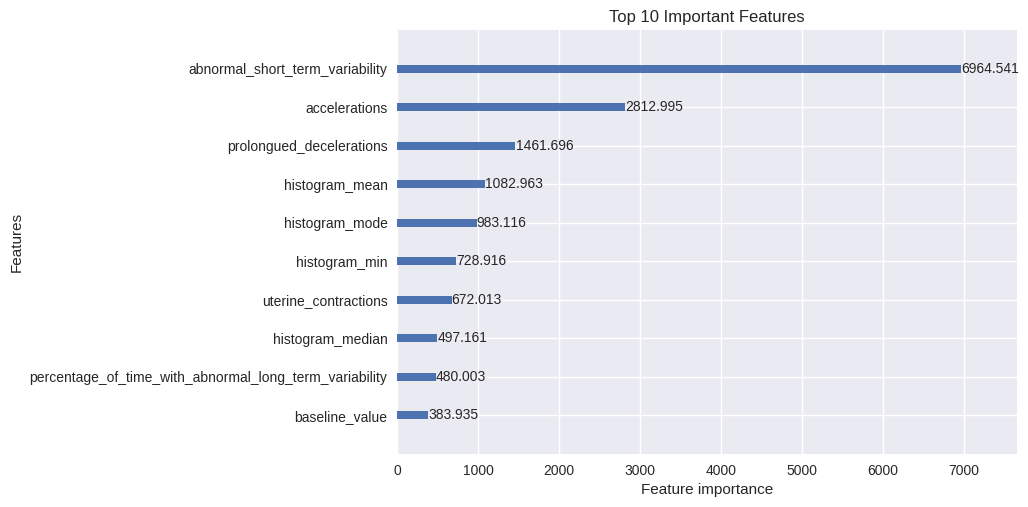

In [ ]:
import lightgbm as lgb

# LightGBM model with SMOTE dataset
lgb_clf = lgb.LGBMClassifier(objective='binary', random_state=1, n_estimators=100)
lgb_clf.fit(smX_train, smy_train)
y_pred = lgb_clf.predict(X_test)
evaluation(y_test, y_pred)

# Feature Importance
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type="gain", title='Top 10 Important Features')
plt.show()


### Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting model
gb_clf = GradientBoostingClassifier(random_state=1)
gb_clf.fit(smX_train, smy_train)
y_pred = gb_clf.predict(X_test)
evaluation(y_test, y_pred)


Evaluation Metrics:
Accuracy: 0.0263
Precision: 0.0912
Recall: 0.0263
F1 Score: 0.0408


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# CTG Classification

In [ ]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import shap
%matplotlib inline

**Data**

This research project utilizes a dataset of 2,126 CTGs. Test measurements form 21 numeric input features related to uterine contractions, fetal movements, as well as several fetal heart rate metrics: baseline beats per minute, accelerations and decelerations, short- and long-term variability, and histogram descriptive statistics. Three expert obstetricians reviewed these CTGs, providing an output label of normal, suspect, or pathological for each test.

In [ ]:
# Read in data, and display preview.
df = pd.read_csv('fetal_health.csv')
pd.set_option('display.max_columns', None)
df.sample(10)

FileNotFoundError: [Errno 2] No such file or directory: 'fetal_health.csv'

In [ ]:
df.shape

(2126, 22)

**Exploratory Data Analysis & Visualization**

During the data preprocessing phase, we confirm the dataset has no missing values, as well as generated descriptive statistics for each input variable. The distribution of output classifications was visually inspected. Due to extreme imbalance, suspect and pathological CTGs were mapped to a single abnormal class, Class 1, and normal CTGs were mapped to Class 0. While improved, the final output classes still suffer from imbalance. For every input variable, boxplots were created to identify features with significant outliers, and histograms were used to visualize feature distributions to determine the most appropriate scaler. After scaling, a correlation heatmap was produced to uncover highly correlated features that might negatively impact Logistic Regression.

**Missing Data**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

**Descriptive Statistic**

In [ ]:
df.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


**Target Balance/Imbalance**

<ipython-input-6-a861917cf0ae>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='fetal_health', palette='ocean_r')


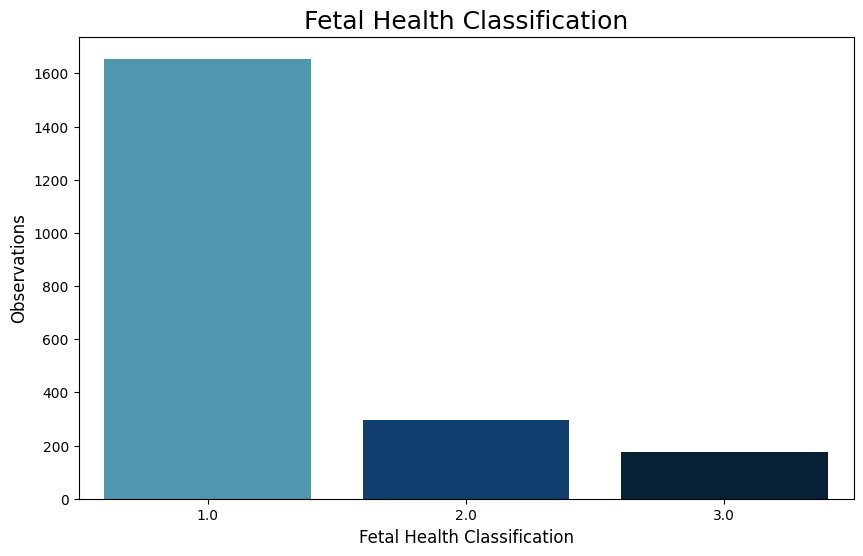

In [ ]:
# Check balance of target variable.
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='fetal_health', palette='ocean_r')
plt.title('Fetal Health Classification', fontsize=18)
plt.xlabel('Fetal Health Classification', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()

In [ ]:
# Given the imbalanced nature of the data, as well as the extremely small number of class 3 observations,
# we create a new target variable of 0 = Normal and 1 = Suspect/Pathological.

df['target'] = df.fetal_health.apply(lambda x: 0 if x == 1 else 1)
df.drop(columns=['fetal_health'], inplace=True)

<ipython-input-8-a9b36d4d7cce>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='target', palette='ocean_r')


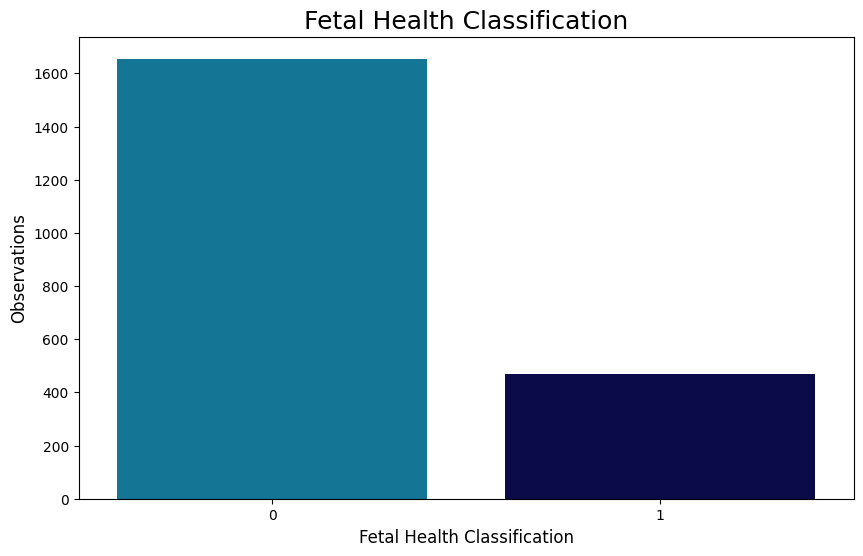

In [ ]:
# Check balance of mapped target variable.
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='target', palette='ocean_r')
plt.title('Fetal Health Classification', fontsize=18)
plt.xlabel('Fetal Health Classification', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()

**Feature Extraction**

Outliers were identified and removed using the interquartile range method, leaving 1,349 observations. Additionally, all input variables were scaled using min-max normalization. Due to several highly correlated features, principal component analysis was performed. Seven principal components were extracted from the original 21 features, maintaining 99.2% of the explained variance. These seven principal components were mapped back to their most correlated feature for later analysis of feature importance. To complete data preprocessing, the final dataset was randomly split into training (70%) and test (30%) sets.

**Outliers**

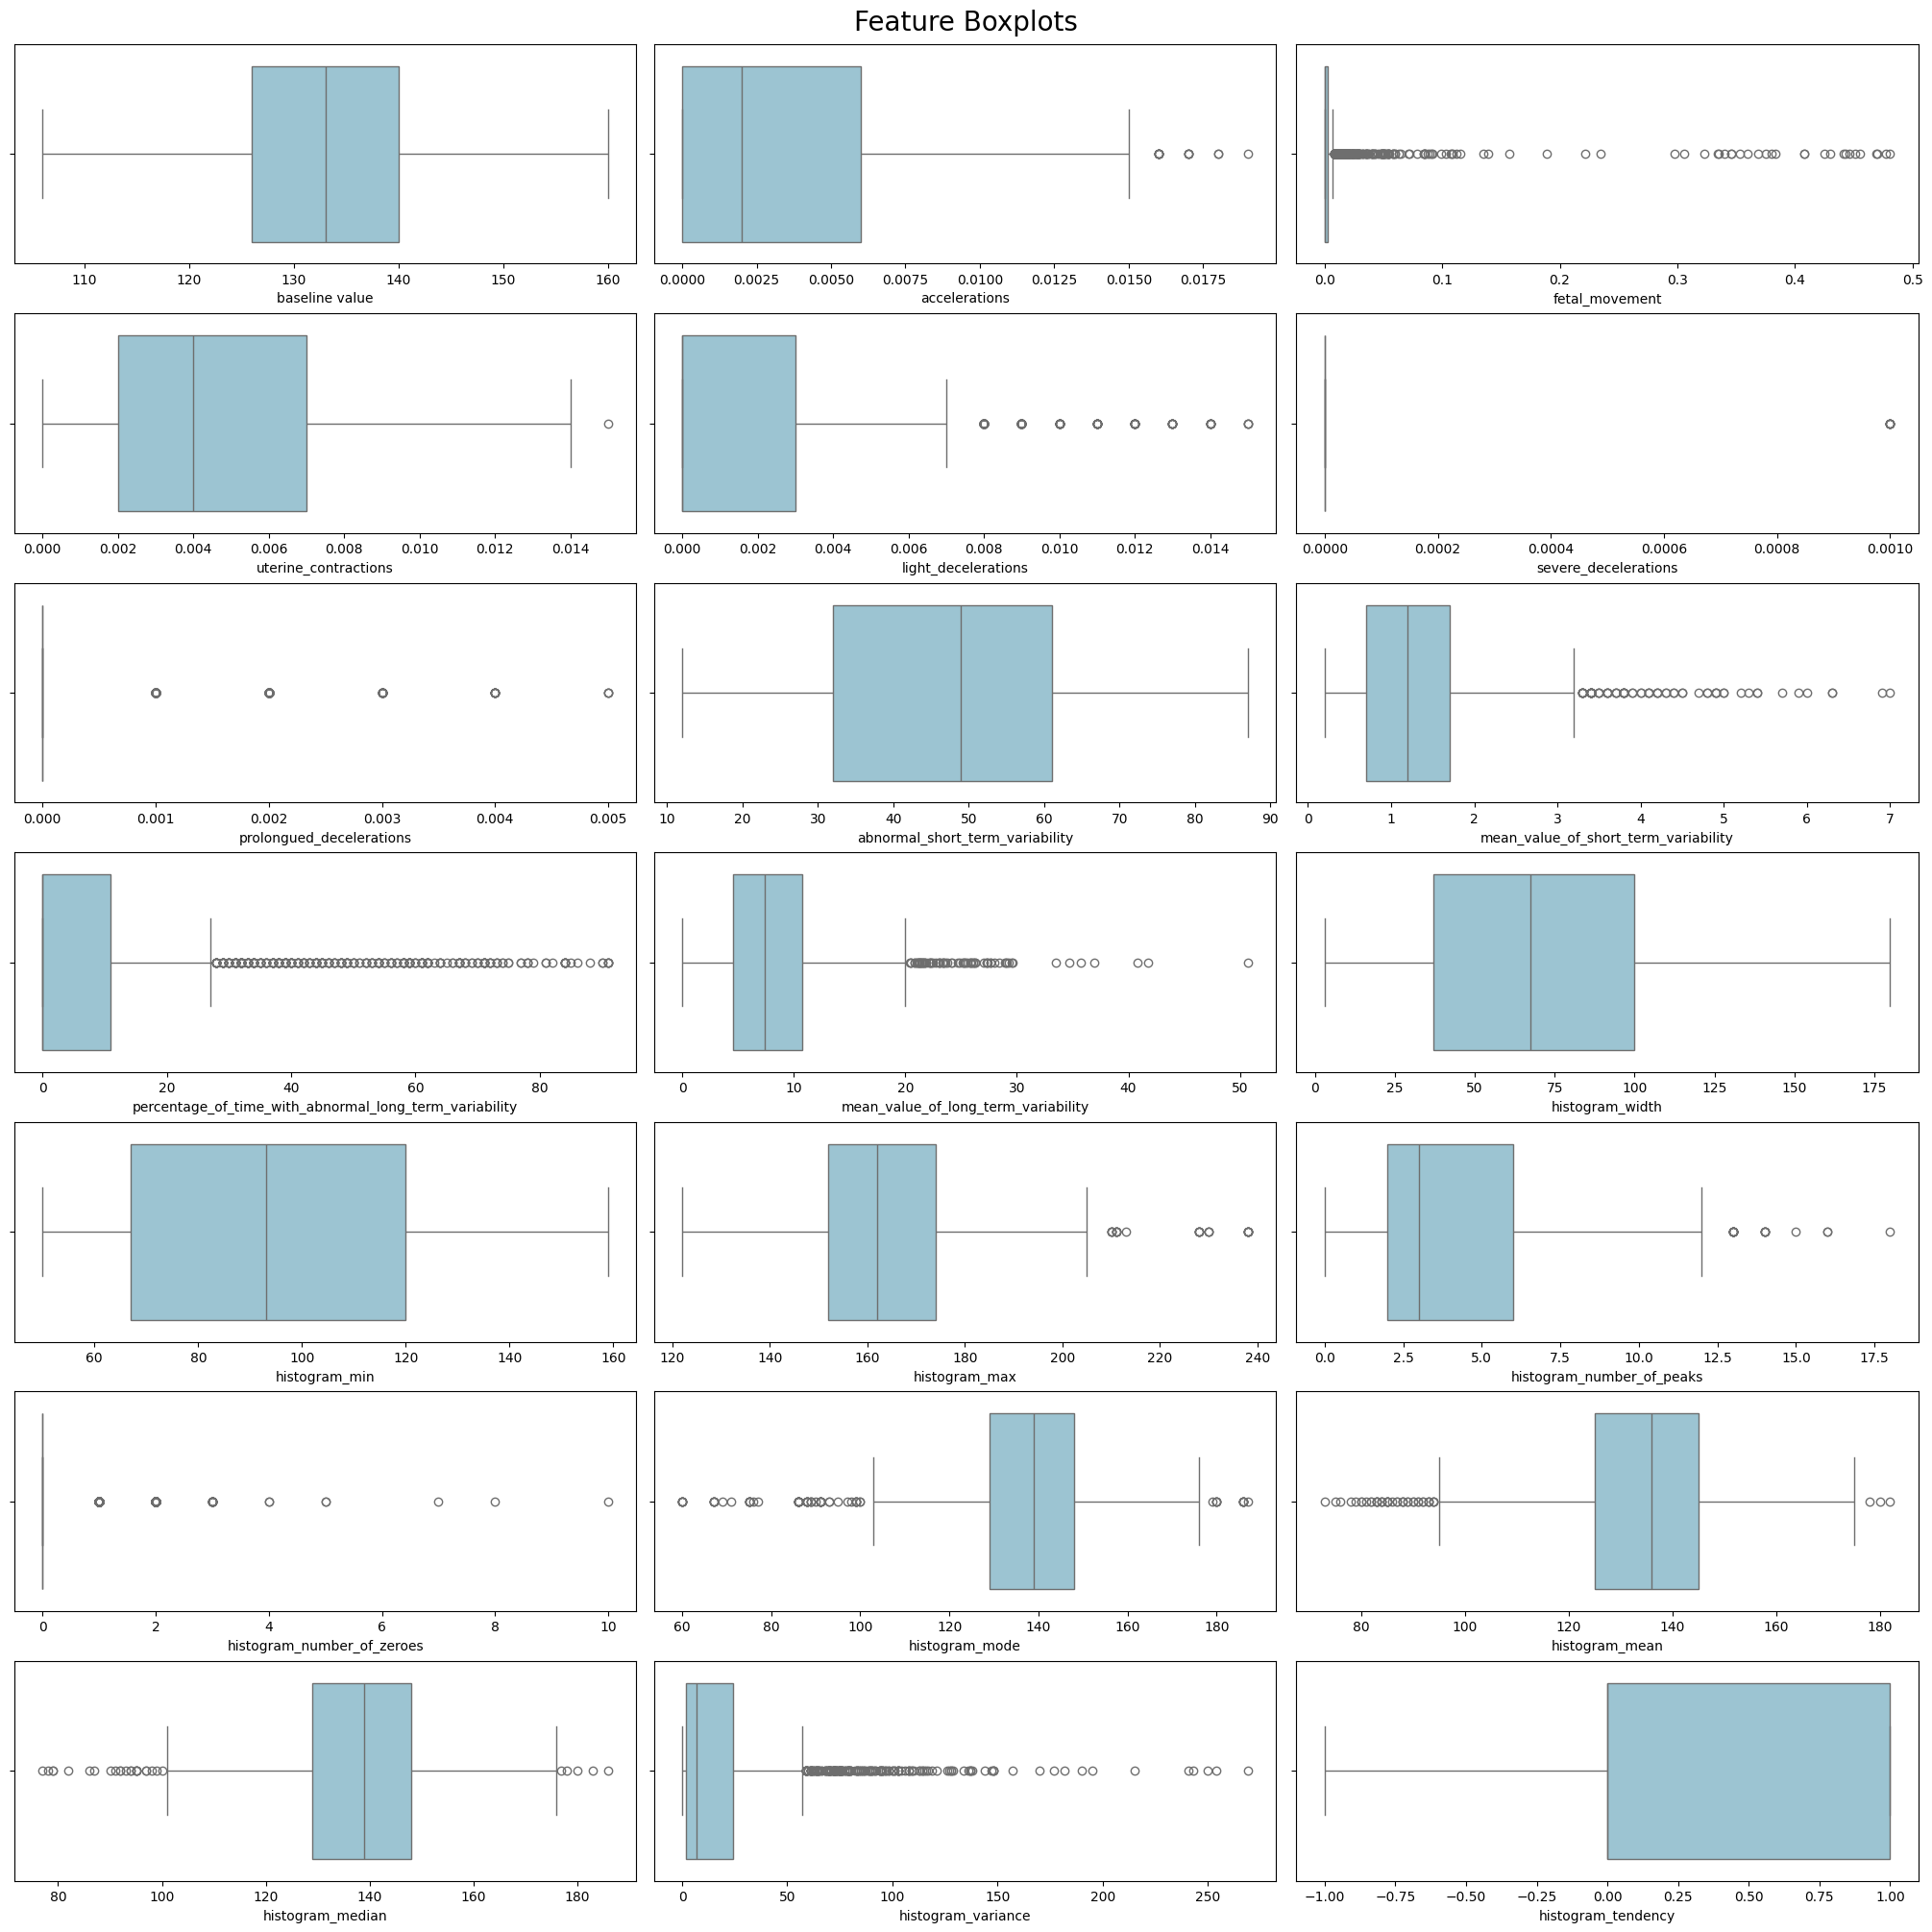

In [ ]:
# Feature boxplots.
features = df.columns[:-1]
l,w = 7,3
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(20,20))
fig.suptitle('Feature Boxplots', fontsize=20)
for i in range(len(features)):
    j,k = plots[i]
    sns.boxplot(x=features[i], data=df, ax=axs[j,k], color='#93c9db')
plt.show()

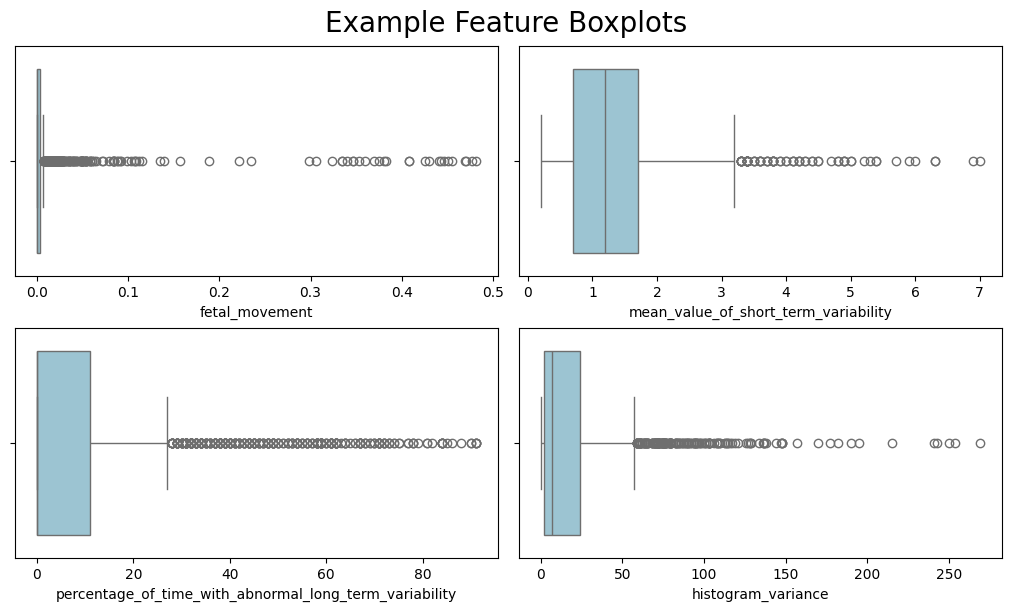

In [ ]:
# Feature boxplots.
outliers = ['fetal_movement','mean_value_of_short_term_variability','percentage_of_time_with_abnormal_long_term_variability','histogram_variance']
l,w = 2,2
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(10,6))
fig.suptitle('Example Feature Boxplots', fontsize=20)
for i in range(len(outliers)):
    j,k = plots[i]
    sns.boxplot(x=outliers[i], data=df[outliers], ax=axs[j,k], color='#93c9db')
plt.show()

In [ ]:
print(sns.color_palette("ocean_r").as_hex())

['#93c9db', '#2492b6', '#005b92', '#00246d', '#001249', '#004924']


In [ ]:
# For each variable, remove values below Q1 - 1.5*IQR and values above Q3 + 1.5*IQR as outliers.
def tag_non_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    cutoff_below = q1 - (1.5 * iqr)
    cutoff_above = q3 + (1.5 * iqr)
    return df[col].apply(lambda x: x <= cutoff_above and x >= cutoff_below)

# Certain features contain a disproportionate number of outliers. If we include these features and remove
# outliers, it cuts the dataset in half. We drop these features.
include_cols = set(df.columns[:-1])
include_cols.remove('fetal_movement')
include_cols.remove('histogram_number_of_zeroes')

df_not_outliers = pd.DataFrame()
for column in include_cols:
    df_not_outliers[column] = tag_non_outliers(df, column)
df_not_outliers['true_cnt'] = df_not_outliers.sum(axis=1)

clean_df = df[df_not_outliers.true_cnt == len(include_cols)].copy()
clean_df.drop(columns=list(set(df.columns[:-1]).difference(include_cols)), inplace=True)

print('Observations prior to removal of outliers:', df.shape[0])
print('Observations after removal of outliers:', clean_df.shape[0])

Observations prior to removal of outliers: 2126
Observations after removal of outliers: 1349


**Data Distributions**

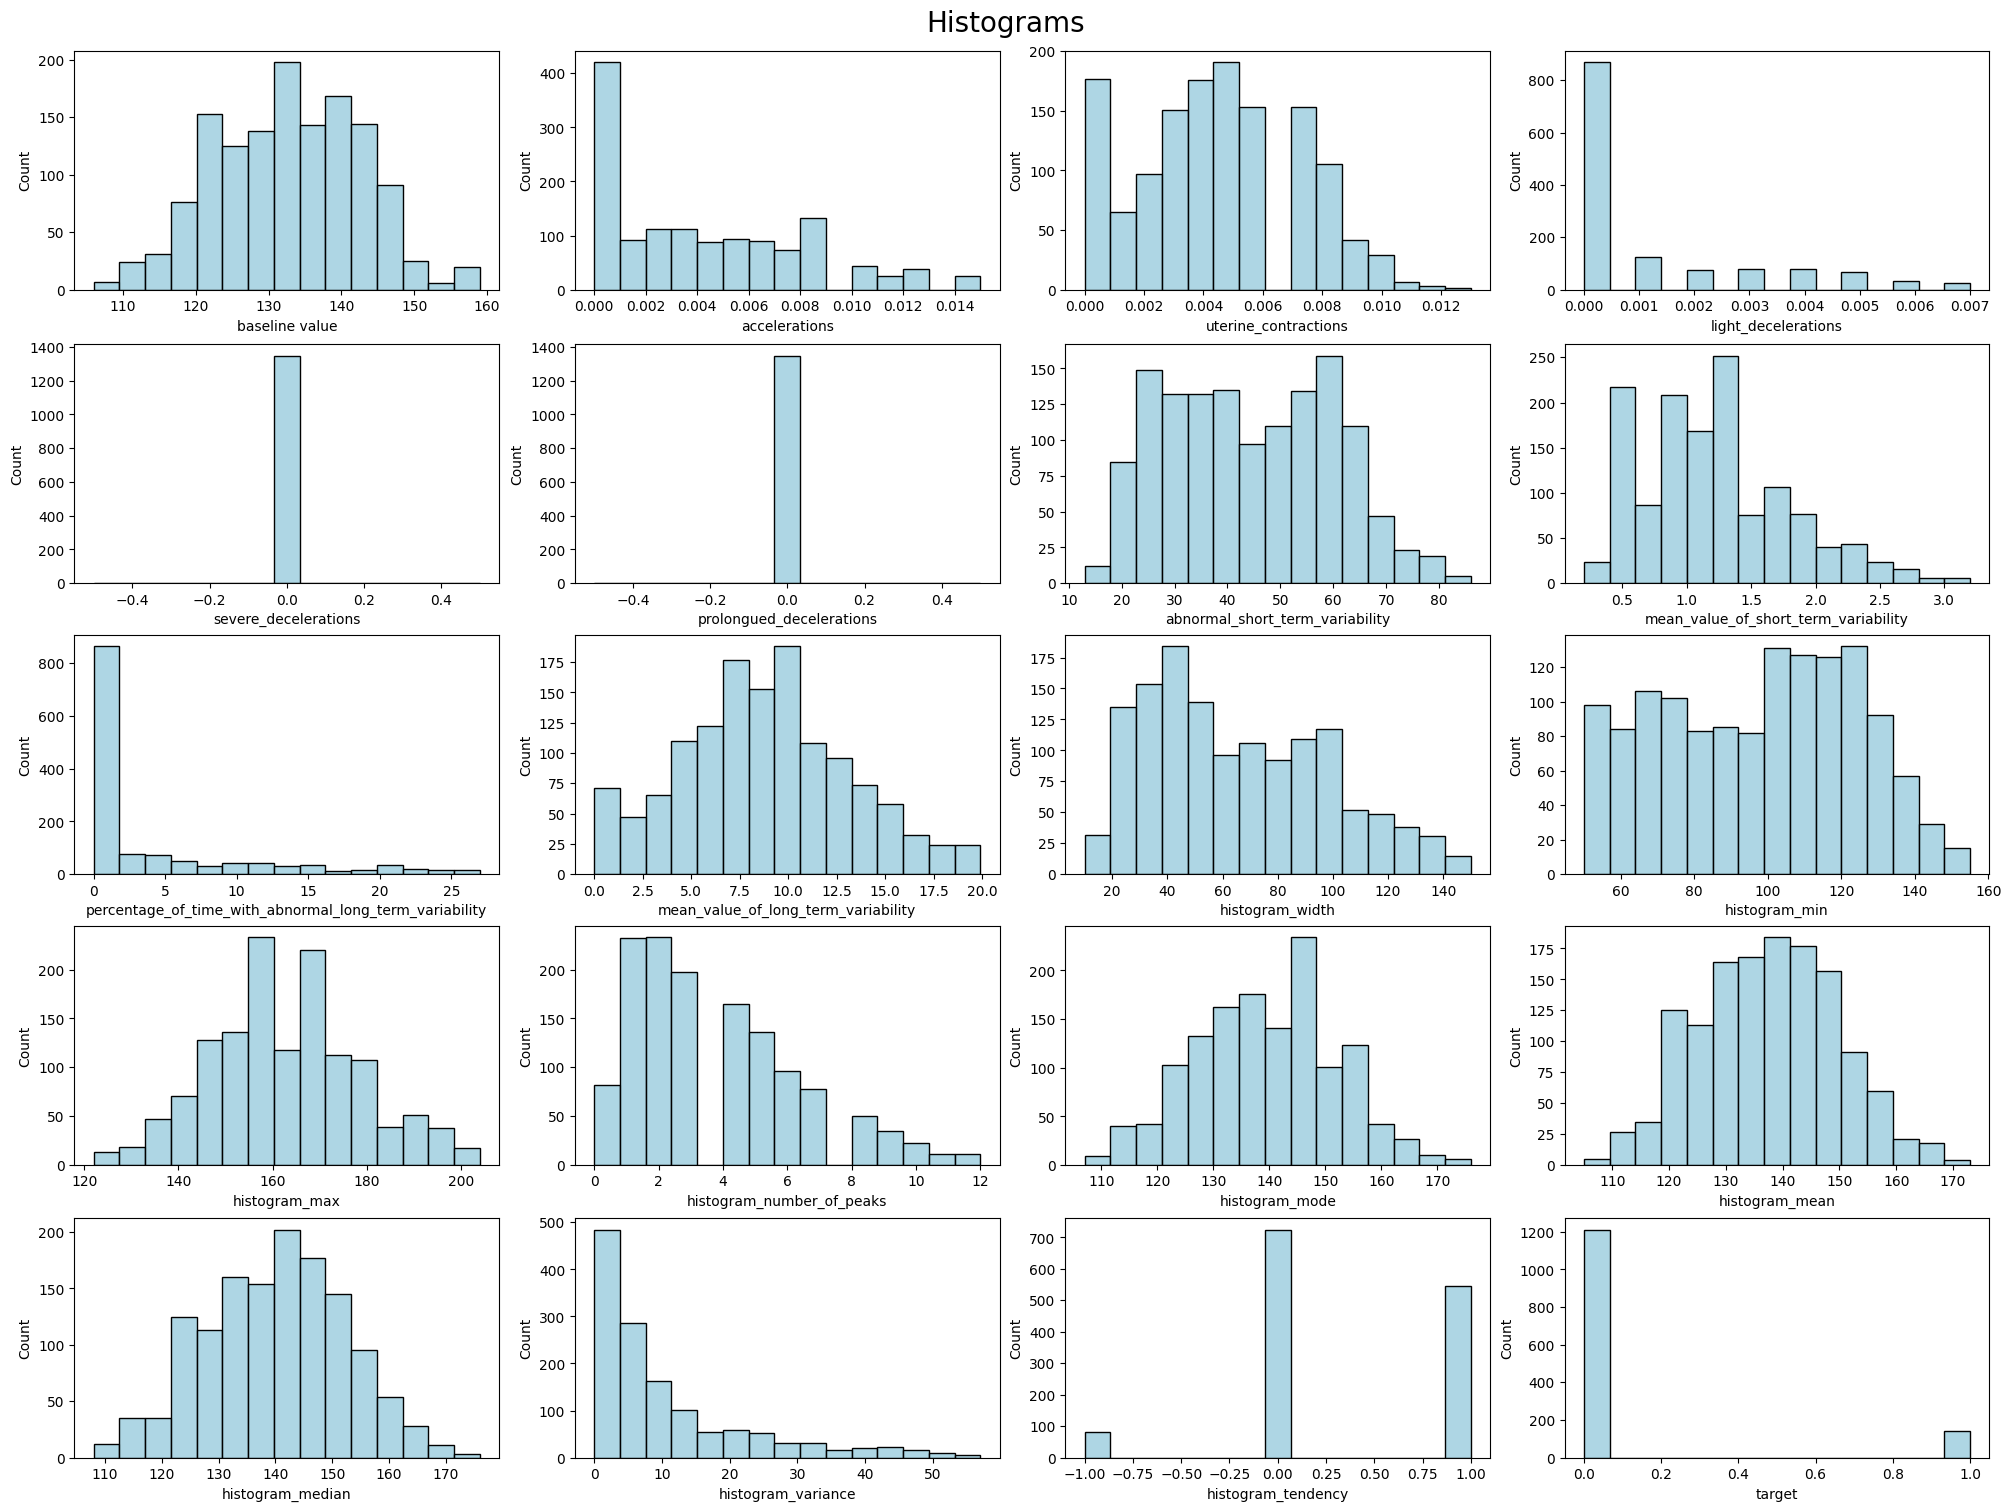

In [ ]:
# Histograms.
l,w = 5,4
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(20,15))
fig.suptitle('Histograms', fontsize=20)
for i in range(len(clean_df.columns)):
    j,k = plots[i]
    sns.histplot(x=clean_df.columns[i], data=clean_df, bins=15, ax=axs[j,k], color='#93c9db')
plt.show()

In [ ]:
# After removal of outliers, two columns have only a single value. These are removed.
clean_df.drop(columns=['severe_decelerations','prolongued_decelerations'], inplace=True)

**Data Transformation**

In [ ]:
# Scale data with MinMaxScaler to retain variance.
minmax = MinMaxScaler()
scaled_df = clean_df.copy()
scaled_df[clean_df.columns[:-1]] = minmax.fit_transform(scaled_df[clean_df.columns[:-1]])
scaled_df.head(10)

,baseline value,accelerations,uterine_contractions,light_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,target
1,0.490566,0.400000,0.461538,0.428571,0.054795,0.633333,0.000000,0.522613,0.857143,0.171429,0.926829,0.500000,0.492754,0.455882,0.470588,0.210526,0.5,0
2,0.509434,0.200000,0.615385,0.428571,0.041096,0.633333,0.000000,0.673367,0.857143,0.171429,0.926829,0.416667,0.492754,0.441176,0.441176,0.228070,0.5,0
4,0.490566,0.466667,0.615385,0.000000,0.041096,0.733333,0.000000,1.000000,0.764286,0.028571,0.585366,0.750000,0.434783,0.455882,0.441176,0.192982,1.0,0
7,0.301887,0.000000,0.000000,0.000000,0.958904,0.100000,0.222222,0.783920,0.414286,0.114286,0.097561,0.000000,0.217391,0.250000,0.220588,0.052632,1.0,1
8,0.301887,0.000000,0.153846,0.000000,0.972603,0.100000,0.185185,0.683417,0.414286,0.114286,0.097561,0.000000,0.217391,0.250000,0.220588,0.052632,1.0,1
9,0.301887,0.000000,0.230769,0.000000,1.000000,0.033333,0.222222,0.532663,0.414286,0.114286,0.097561,0.083333,0.217391,0.250000,0.220588,0.017544,1.0,1
12,0.471698,0.333333,0.615385,0.428571,0.205479,0.400000,0.000000,0.648241,0.400000,0.361905,0.390244,0.416667,0.405797,0.426471,0.426471,0.122807,1.0,0
13,0.471698,0.600000,0.461538,0.285714,0.205479,0.433333,0.000000,0.271357,0.550000,0.200000,0.439024,0.166667,0.492754,0.470588,0.485294,0.175439,1.0,0
23,0.415094,0.000000,0.000000,0.000000,0.917808,0.100000,0.000000,0.341709,0.042857,0.609524,0.097561,0.000000,0.275362,0.279412,0.250000,0.017544,1.0,1
26,0.339623,0.000000,0.000000,0.000000,1.000000,0.066667,0.518519,0.241206,0.100000,0.685714,0.292683,0.083333,0.275362,0.308824,0.279412,0.000000,0.0,1


**Feature Correalation**

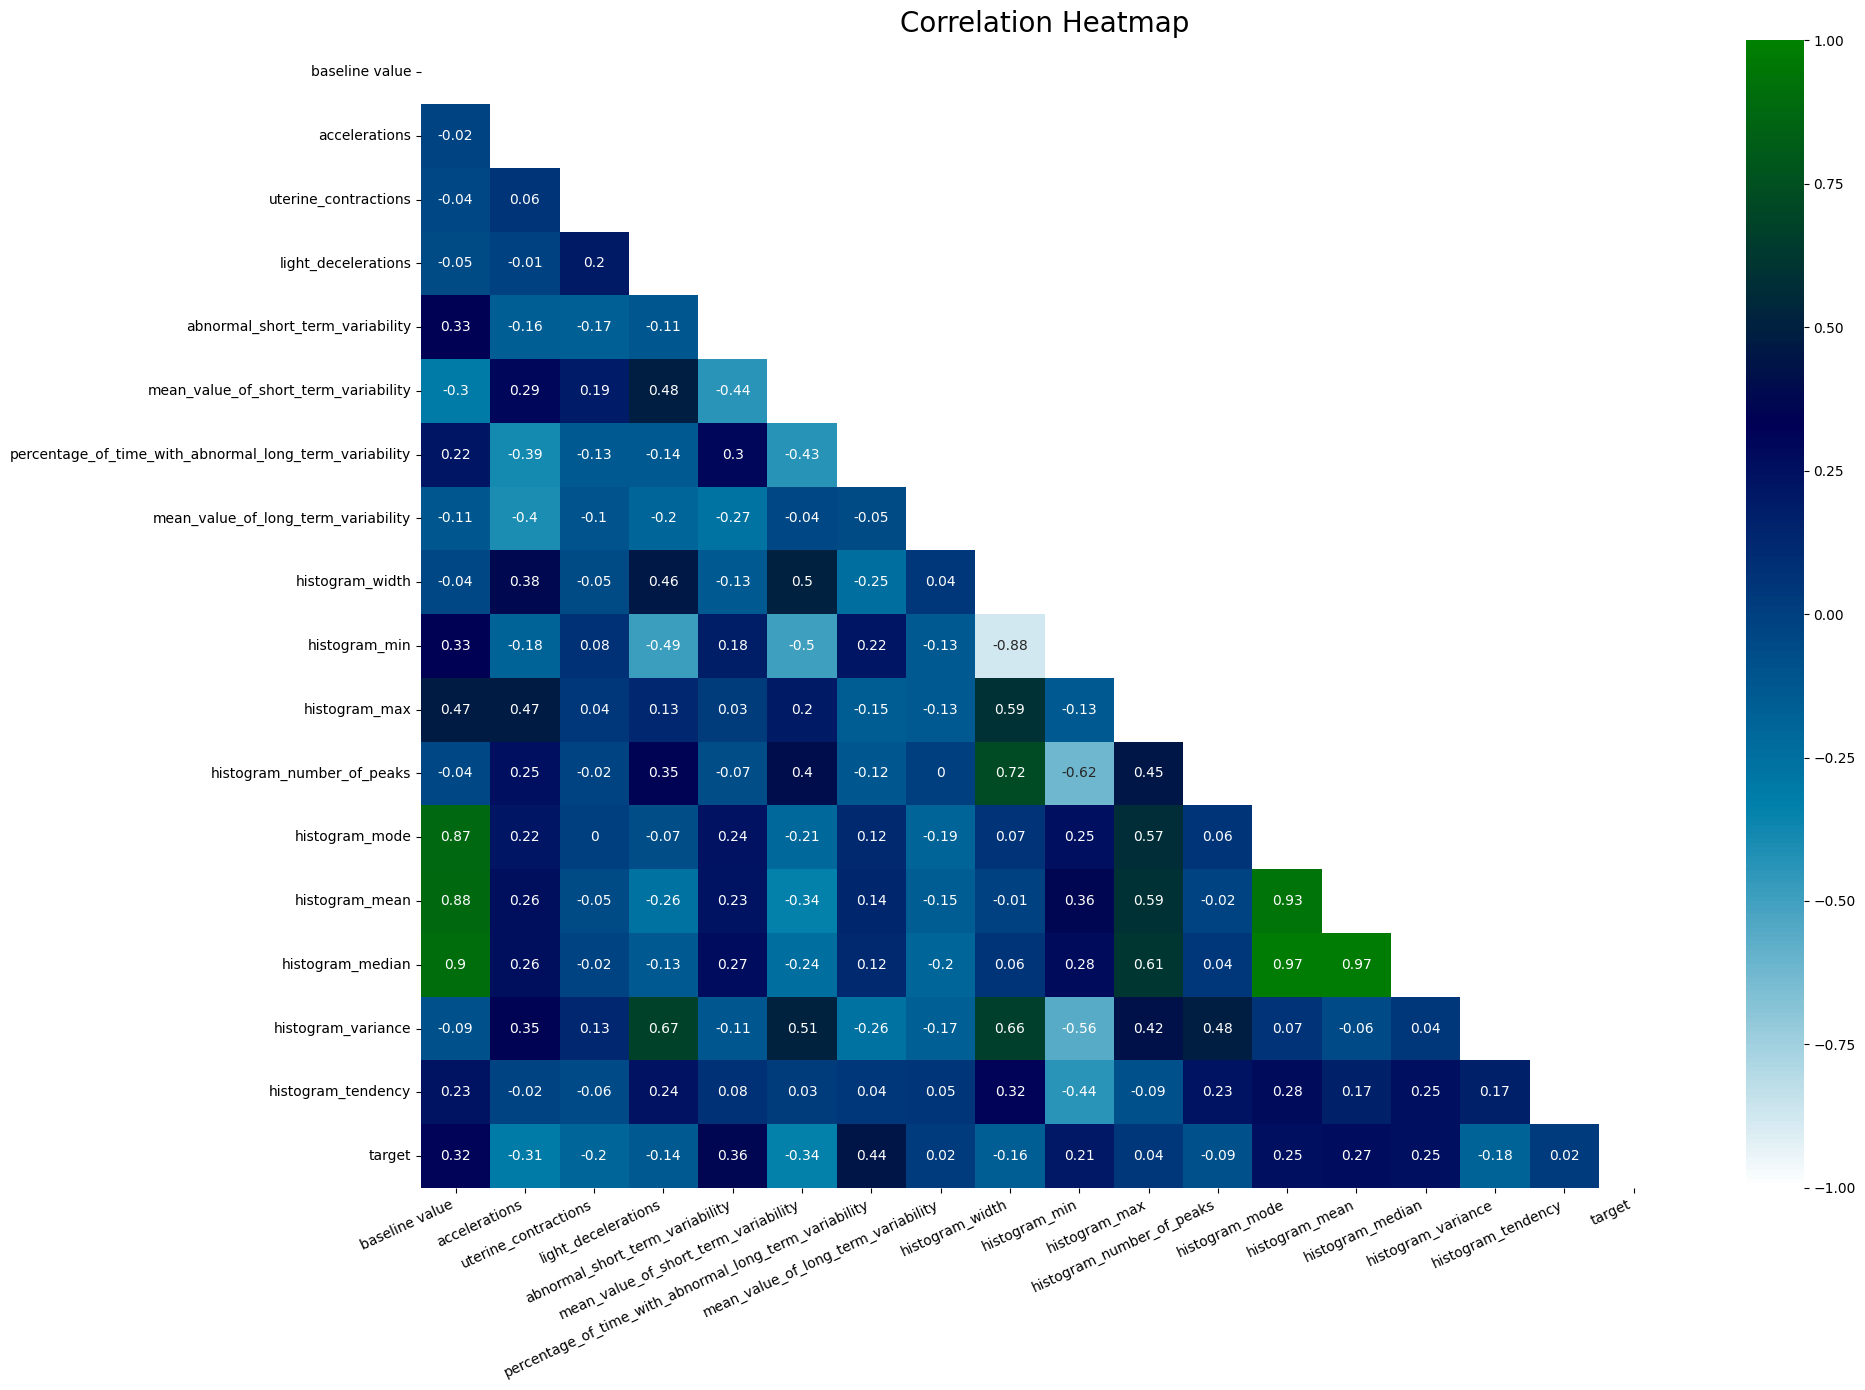

In [ ]:
# Several features appear to be highly correlated to each other.
corr_matrix = clean_df.corr()
fig, ax = plt.subplots(figsize=(20,14))
mask = np.zeros_like(corr_matrix, dtype=bool)   # returns an array of False values with same shape as corr dataframe
mask[np.triu_indices_from(mask)] = True  # creates a boolean mask by making half the zero values == True
ax = sns.heatmap(corr_matrix.round(2), mask=mask, ax=ax, annot=True, vmin=-1, vmax=1, annot_kws={'fontsize':10}, cmap='ocean_r')
ax.set_xticklabels(ax.xaxis.get_ticklabels())
ax.set_yticklabels(ax.yaxis.get_ticklabels())
plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Define arrays for remainder of analysis.
X = clean_df.drop('target', axis=1)
y = clean_df['target'].copy()

In [ ]:
sns.color_palette('ocean_r').as_hex()

['#93c9db', '#2492b6', '#005b92', '#00246d', '#001249', '#004924']

In [ ]:
print(sns.color_palette('ocean_r').as_hex())

['#93c9db', '#2492b6', '#005b92', '#00246d', '#001249', '#004924']


## **PCA**

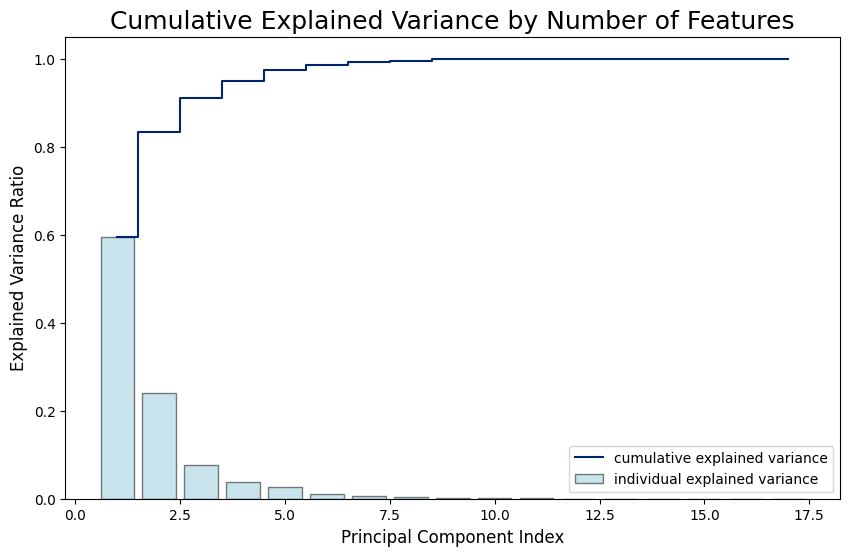

In [ ]:
# Compute covariance matrix, and visualize cumulative sum of explained variances to choose right number of PCA dimensions.
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Calculate cumulative sum of explained variances.
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Plot explained variances
plt.figure(figsize=(10,6))
plt.bar(range(1,18), var_exp, alpha=0.5, align='center', label='individual explained variance', color='#93c9db', edgecolor = 'black')
plt.step(range(1,18), cum_var_exp, where='mid', label='cumulative explained variance', color='#00246d')
plt.title('Cumulative Explained Variance by Number of Features', fontsize=18)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xlabel('Principal Component Index', fontsize=12)
plt.legend(loc='best')
plt.show()

In [ ]:
# 99% of the variance is explained with seven components.
print(f'Cumulative explained variance from PCA components: {cum_var_exp[6]:.3f}.')
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)

Cumulative explained variance from PCA components: 0.992.


In [ ]:
# Let's try to understand how principal components are related to our features.
pca_features = pd.DataFrame(pca.components_,columns=clean_df.columns[:-1],
                            index=[1,2,3,4,5,6,7]).reset_index()
pca_features.rename(columns={'index':'PC'}, inplace=True)
pca_features

,PC,baseline value,accelerations,uterine_contractions,light_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,1,-0.034825,0.000031,-2.741036e-06,0.000022,-0.067018,0.007306,-0.041675,0.006414,0.761092,-0.584469,0.176623,0.044225,-0.011799,-0.037211,-0.016135,0.191419,0.004795
1,2,0.319220,0.000041,-9.633906e-07,-0.000007,0.186990,-0.004432,0.025467,-0.035264,0.168193,0.278767,0.446960,0.010603,0.434026,0.422785,0.431663,0.043278,0.002084
2,3,0.056474,-0.000064,-3.821224e-05,0.000001,0.932674,-0.012459,0.141991,-0.053327,-0.009598,-0.215900,-0.225498,0.002804,-0.014917,-0.051627,-0.010949,-0.055761,0.009518
3,4,-0.266322,0.000072,3.542958e-05,0.000020,0.258316,0.009174,-0.124557,-0.098960,0.095694,0.430354,0.526048,0.017238,-0.310464,-0.247168,-0.258979,0.373868,-0.035229
4,5,0.034921,0.000036,5.475919e-05,0.000099,-0.039318,0.010474,-0.074471,-0.134430,-0.215663,-0.092374,-0.308037,-0.015629,0.226228,0.002155,0.130993,0.868728,0.017366
5,6,0.060244,-0.000171,-1.494725e-05,0.000032,-0.118732,-0.010977,0.970082,-0.010176,0.024763,0.050275,0.075039,0.034658,-0.055952,-0.057781,-0.072961,0.138494,-0.006662
6,7,0.536323,-0.000463,-2.472953e-05,0.000050,0.037780,-0.004490,-0.073028,0.785113,-0.012387,0.035275,0.022888,-0.024814,-0.175066,-0.092733,-0.135821,0.170114,-0.001697


In [ ]:
# Find lables for principal components
principal_components = [pca_features.columns[1:][np.argmax(abs(pca_features[pca_features.columns[1:]][ pca_features['PC'] == i + 1 ]))] for i in range(7)]
principal_components[1] = 'histogram_mode'      ## Very close tie between histogram_max / histogram_mode, so leaving PC-4 as histogram_max
principal_components

['histogram_width',
 'histogram_mode',
 'abnormal_short_term_variability',
 'histogram_max',
 'histogram_variance',
 'percentage_of_time_with_abnormal_long_term_variability',
 'mean_value_of_long_term_variability']

In [ ]:
# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=36)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(944, 7) (944,)
(405, 7) (405,)


**Model Building and Optimization**

Initial Random Forest, Logistic Regression, and K-Nearest Neighbor models were constructed, and baseline scores were generated for both training and test datasets. Like other medical diagnostic tools, false negatives are far more harmful than false positives, as false negatives prevent patients from receiving the care they need. Because of this, we placed far more emphasis on recall and ROC AUC scores during model evaluation. Prior to tuning, Random Forest was quite overfitted, and all three models had low recall scores for test data.

For hyperparameter tuning, we utilized grid search k-fold cross-validation. Max depth and out-of-bag scoring eliminated Random Forest overfitting. Lasso regularization was applied to Logistic Regression, and the number of neighbors, leaf size, and distance metric parameters were tuned for K-Nearest Neighbors. Of the many parameters tested, class weight had the greatest impact for both Random Forest and Logistic Regression in improving model outcomes.

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=36)
rf_clf.fit(X_train, y_train)

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=36)
log_reg.fit(X_train, y_train)

In [ ]:
# K-Nearest Neighbors
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

In [ ]:
models = [ rf_clf, log_reg, knn_clf ]

table_train = PrettyTable()
table_test = PrettyTable()
fields = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
table_train.field_names = fields
table_test.field_names = fields

for model in models:
    # Training metrics.
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_train = roc_auc_score(y_train, y_pred_train)
    table_train.add_row([type(model).__name__, format(accuracy_train, '.3f'), format(precision_train, '.3f'), format(recall_train,'.3f'),
                         format(f1_train,'.3f'), format(roc_train,'.3f')])

    # Test metrics.
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test)
    table_test.add_row([type(model).__name__, format(accuracy_test, '.3f'), format(precision_test, '.3f'), format(recall_test,'.3f'),
                         format(f1_test,'.3f'), format(roc_test,'.3f')])


print('BASELINE SCORES FOR TRAINING DATA')
print(table_train)
print('\n\nBASELINE SCORES FOR TEST DATA')
print(table_test)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

In [ ]:
# Logistic Regression ROC Curve Data
preds_lr = cross_val_predict(log_reg, X_train, y_train, cv=3, method='predict_proba')
scores_lr = preds_lr[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, scores_lr)

# KNN ROC Curve Data
preds_knn = cross_val_predict(knn_clf, X_train, y_train, cv=3, method='predict_proba')
scores_knn = preds_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, scores_knn)

# Random Forest ROC Curve Data
preds_rf = cross_val_predict(rf_clf, X_train, y_train, cv=3, method='predict_proba')
scores_rf = preds_rf[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, scores_rf)

In [ ]:
# ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label='K-Nearest Neighbors', color='#93c9db')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='Logistic Regression', color='#005b92')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label='Random Forest', color='#004924')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title('ROC Curves', fontsize=18)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

# **Hyperparameter Tuning**

**Random Forest **

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=36)
rf_pg = {
    'n_estimators': [50, 70, 100],
    'max_depth': [2, 3, 5],
    'oob_score': [True, False],
    'class_weight': [{0:.09, 1:.91}, {0:.1, 1:.9}]
}
rf_grid = GridSearchCV(rf, param_grid=rf_pg, cv=10, scoring='recall')
with joblib.parallel_backend('threading', n_jobs=4):
    rf_grid.fit(X_train, y_train)

# Print best parameters.
rf_grid.best_params_

In [ ]:
# Use best model to find new metrics.
rf_final = rf_grid.best_estimator_
rf_final.fit(X_train, y_train)
print('Random Forest Classification Report:')
print(classification_report(y_train, rf_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, rf_final.predict(X_train)):.3f}')

In [ ]:
# Logistic Regression GridSearchCV
lr = LogisticRegression(max_iter=5000, random_state=36)
lr_pg = {
    'penalty': ['l1','l2'],
    'solver': ['liblinear','saga'],
    'class_weight': [{0:.01, 1:.99}, {0:.1, 1:.9}, {0:.15, 1:.85}],
    'C': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
}
lr_grid = GridSearchCV(lr, param_grid=lr_pg, cv=10, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

# Print best parameters.
lr_grid.best_params_

In [ ]:
# Use best model to find new metrics.
lr_final = lr_grid.best_estimator_
lr_final.fit(X_train, y_train)
print('Logistic Regression Classification Report:')
print(classification_report(y_train, lr_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, lr_final.predict(X_train)):.3f}')

**K-Nearest Neighbors**

In [ ]:
# KNN
knn = KNeighborsClassifier()
knn_pg = {
    'n_neighbors': [ i for i in range(5,15) ],
    'leaf_size': [10,30,50],
    'algorithm': ['ball_tree','kd_tree'],
    'p': [1,2],
    'metric':['minkowski','chebyshev']
}
knn_grid = GridSearchCV(knn, param_grid=knn_pg, cv=10, scoring='recall')
with joblib.parallel_backend('threading', n_jobs=4):
    knn_grid.fit(X_train, y_train)

# Print best parameters.
knn_grid.best_params_

In [ ]:
# Use best model to find new metrics.
knn_final = knn_grid.best_estimator_
knn_final.fit(X_train, y_train)
print('K-Nearest Neighbors Classification Report:')
print(classification_report(y_train, knn_final.predict(X_train)))
print(f'ROC AUC: {roc_auc_score(y_train, knn_final.predict(X_train)):.3f}')

Random Forest slightly edges out Logistic Regression for the best Recall for Class 1.

# **ROC Curves**

In [ ]:
# Logistic Regression ROC Curve Data
preds_lr = cross_val_predict(lr_final, X_train, y_train, cv=3, method='predict_proba')
scores_lr = preds_lr[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, scores_lr)

# KNN ROC Curve Data
preds_knn = cross_val_predict(knn_final, X_train, y_train, cv=3, method='predict_proba')
scores_knn = preds_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, scores_knn)

# Random Forest ROC Curve Data
preds_rf = cross_val_predict(rf_final, X_train, y_train, cv=3, method='predict_proba')
scores_rf = preds_rf[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, scores_rf)

In [ ]:
# ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, linewidth=2, label='K-Nearest Neighbors', color='#93c9db')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='Logistic Regression', color='#005b92')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label='Random Forest', color='#004924')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title('ROC Curves', fontsize=18)
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

**Model Comparison**

Final models for Random Forest and Lasso Logistic Regression performed similarly, with Random Foresting achieving slightly higher recall and ROC AUC scores for both test and training. Tuning did not appear to improve K-Nearest Neighbors, which maintained high accuracy but ultimately had poor recall. In addition to scoring, comparison ROC curves (Figure 10) and confusion matrices were generated, confirming Random Forest as the best model with 94.4% recall and 89.5% ROC AUC on test data.

# **Summary Tables**

In [ ]:
models = [ rf_final, lr_final, knn_final ]

table_train = PrettyTable()
table_test = PrettyTable()
fields = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
table_train.field_names = fields
table_test.field_names = fields

for model in models:
    model.fit(X_train, y_train)

    # Training metrics.
    y_pred_train = model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_train = roc_auc_score(y_train, y_pred_train)
    table_train.add_row([type(model).__name__, format(accuracy_train, '.3f'), format(precision_train, '.3f'), format(recall_train,'.3f'),
                         format(f1_train,'.3f'), format(roc_train,'.3f')])

    # Test metrics.
    y_pred_test = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_test = roc_auc_score(y_test, y_pred_test)
    table_test.add_row([type(model).__name__, format(accuracy_test, '.3f'), format(precision_test, '.3f'), format(recall_test,'.3f'),
                         format(f1_test,'.3f'), format(roc_test,'.3f')])


print('FINAL SCORES FOR TRAINING DATA')
print(table_train)
print('\n\nFINAL SCORES FOR TEST DATA')
print(table_test)

**Confusion Matrices**

In [ ]:
# Random Forest Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(rf_final, X_train, y_train, ax=axes[0], cmap='ocean_r')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(rf_final, X_test, y_test, ax=axes[1], cmap='ocean_r')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('Random Forest', fontsize=20)
plt.show()

In [ ]:
# Logistic Regression Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(lr_final, X_train, y_train, ax=axes[0], cmap='ocean_r')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(lr_final, X_test, y_test, ax=axes[1], cmap='ocean_r')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('Logistic Regression', fontsize=20)
plt.show()

In [ ]:
# K-Nearest Neighbors Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18,6))
ConfusionMatrixDisplay.from_estimator(knn_final, X_train, y_train, ax=axes[0], cmap='ocean_r')
axes[0].set_title('Training Set Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(knn_final, X_test, y_test, ax=axes[1], cmap='ocean_r')
axes[1].set_title('Test Set Confusion Matrix')
plt.suptitle('K-Nearest Neighbors', fontsize=20)
plt.show()

**Feature Importance**

In [ ]:
# Random Forest
rf_explainer = shap.TreeExplainer(rf_final)
rf_shap_values = rf_explainer.shap_values(X_train, approximate=True)
fig = plt.figure(figsize=(15,10))
shap.summary_plot(rf_shap_values, features=X_train, feature_names=principal_components, plot_type='bar', show=False)
plt.title('Random Forest SHAP Values', fontsize=16)
plt.show()

In [ ]:
# Logistic Regression
lr_coeff = pd.DataFrame(zip(principal_components, lr_final.coef_[0].transpose()), columns=['principal_component','coefficient'])
lr_coeff.sort_values(by=['coefficient'], ascending=False, inplace=True)
lr_coeff

**Conclusion**

In our efforts to compare Random Forest, Logistic Regression, and K-Nearest Neighbors in predicting normal vs. abnormal CTG results, we found Random Forest was the best model. Furthermore, CTG fetal heart rate histogram mode, abnormal short-term variability, and percentage of time with long-term variability were the most influential features. Tuning for recall increased the number of false positives, decreasing the overall accuracy. A high number of outliers significantly decreased our sample size, and we recommend gathering additional CTGs readings to determine if a larger sample would improve results.